<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(you can write your own for loops refer sample solution)</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points`</li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
   

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "drive/My Drive/Colab Notebooks"

In [ ]:
import pandas as pd
data = pd.read_csv(path+"/preprocessed_data.csv")
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


## Sentiment Scores of Preprocessed Essay

In [ ]:
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid    = SentimentIntensityAnalyzer()
negative = []
positive = []
neutral = []
compound = []
def update_sentiments(values):
    negative.append(values["neg"])    
    positive.append(values["pos"])
    neutral.append(values["neu"])
    compound.append(values["compound"])
from tqdm import tqdm
for essay in tqdm(data["essay"]):
    update_sentiments(sid.polarity_scores(essay))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
100%|██████████| 109248/109248 [03:19<00:00, 546.95it/s]


In [ ]:
data['negative'] = negative
data['positive'] = positive
data['neutral'] = neutral
data['compound'] = compound

data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,negative,positive,neutral,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.248,0.680,0.9897


In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,negative,positive,neutral,compound
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867


### Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y) 

##Encoding Categorical Features: Essay

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit(X_train['essay'].values)
X_train_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_tfidf = vectorizer.transform(X_test['essay'].values)

##Encoding Categorical Features: Teacher Prefix




In [ ]:
vectorizer2 = CountVectorizer()
vectorizer2.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer2.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer2.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer2.get_feature_names())
print("="*100)

After vectorizations
(73196, 5) (73196,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


##Encoding Categorical Features: Project Grade

In [ ]:
vectorizer3 = CountVectorizer()
vectorizer3.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer3.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer3.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer3.get_feature_names())
print("="*100)

After vectorizations
(73196, 4) (73196,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


##Encoding Categorical Features: School State

In [ ]:
vectorizer4 = CountVectorizer()
vectorizer4.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer4.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer4.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer4.get_feature_names())
print("="*100)

After vectorizations
(73196, 51) (73196,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


##Encoding Categorical Features: Clean Categories

In [ ]:
vectorizer5 = CountVectorizer()
vectorizer5.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_ohe = vectorizer5.transform(X_train['clean_categories'].values)
X_test_clean_ohe = vectorizer5.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_ohe.shape, y_train.shape)
print(X_test_clean_ohe.shape, y_test.shape)
print(vectorizer5.get_feature_names())
print("="*100)

After vectorizations
(73196, 9) (73196,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


##Encoding Categorical Features: Clean Sub Categories

In [ ]:
vectorizer6 = CountVectorizer()
vectorizer6.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_sub_ohe = vectorizer6.transform(X_train['clean_subcategories'].values)
X_test_clean_sub_ohe = vectorizer6.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_sub_ohe.shape, y_train.shape)
print(X_test_clean_sub_ohe.shape, y_test.shape)
print(vectorizer6.get_feature_names())
print("="*100)

After vectorizations
(73196, 30) (73196,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


##Encoding Numerical Features: Price

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


##Encoding Numerical Features: Previous Project

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_previous_project_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previous_project_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_previous_project_norm.shape, y_train.shape)
print(X_test_previous_project_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


##Sentiment Scores : Negative

In [ ]:
sentiments_standardizer = StandardScaler()

# First applying the .fit() on the train data to find Mean and SD
sentiments_standardizer.fit(X_train['negative'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_negative_sent_standardized = sentiments_standardizer.transform(X_train['negative'].values.reshape(-1,1))
X_test_negative_sent_standardized = sentiments_standardizer.transform(X_test['negative'].values.reshape(-1,1))

print('After Standardizing on negative column checking the shapes ')
print(X_train_negative_sent_standardized.shape, y_train.shape)
print(X_test_negative_sent_standardized.shape, y_test.shape)

After Standardizing on negative column checking the shapes 
(73196, 1) (73196,)
(36052, 1) (36052,)


##Sentiment Scores : Positive

In [ ]:
sentiments_standardizer.fit(X_train['positive'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_positive_sent_standardized = sentiments_standardizer.transform(X_train['positive'].values.reshape(-1,1))
X_test_positive_sent_standardized = sentiments_standardizer.transform(X_test['positive'].values.reshape(-1,1))

print('After Standardizing on positive column checking the shapes ')
print(X_train_positive_sent_standardized.shape, y_train.shape)
print(X_test_positive_sent_standardized.shape, y_test.shape)

After Standardizing on positive column checking the shapes 
(73196, 1) (73196,)
(36052, 1) (36052,)


##Sentiment Scores : Neutral

In [ ]:
# First applying the .fit() on the train data to find Mean and SD
sentiments_standardizer.fit(X_train['neutral'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_neutral_sent_standardized = sentiments_standardizer.transform(X_train['neutral'].values.reshape(-1,1))
X_test_neutral_sent_standardized = sentiments_standardizer.transform(X_test['neutral'].values.reshape(-1,1))

print('After Standardizing on neutral column checking the shapes ')
print(X_train_neutral_sent_standardized.shape, y_train.shape)
print(X_test_neutral_sent_standardized.shape, y_test.shape)

After Standardizing on neutral column checking the shapes 
(73196, 1) (73196,)
(36052, 1) (36052,)


##Sentiment Scores : Compound

In [ ]:
sentiments_standardizer.fit(X_train['compound'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_compound_sent_standardized = sentiments_standardizer.transform(X_train['compound'].values.reshape(-1,1))
X_test_compound_sent_standardized = sentiments_standardizer.transform(X_test['compound'].values.reshape(-1,1))

print('After Standardizing on compound column checking the shapes ')
print(X_train_compound_sent_standardized.shape, y_train.shape)
print(X_test_compound_sent_standardized.shape, y_test.shape)

After Standardizing on compound column checking the shapes 
(73196, 1) (73196,)
(36052, 1) (36052,)


## Stacking All Vectorized Features

In [ ]:
from scipy.sparse import hstack
X_tr_set_one = hstack((X_train_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,X_train_clean_ohe,X_train_clean_sub_ohe,X_train_previous_project_norm,X_train_negative_sent_standardized ,X_train_positive_sent_standardized,X_train_neutral_sent_standardized,X_train_compound_sent_standardized)).tocsr()
X_te_set_one = hstack((X_test_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,X_test_clean_ohe,X_test_clean_sub_ohe,X_test_previous_project_norm,X_test_negative_sent_standardized ,X_test_positive_sent_standardized,X_test_neutral_sent_standardized,X_test_compound_sent_standardized)).tocsr()

In [ ]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_tr_set_one.shape)
print(X_te_set_one.shape)

SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 14332)
(36052, 14332)


### Applying Decision Tree on Set 1

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

DT= DecisionTreeClassifier(class_weight='balanced') 
clf = GridSearchCV(DT, parameters, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(X_tr_set_one,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

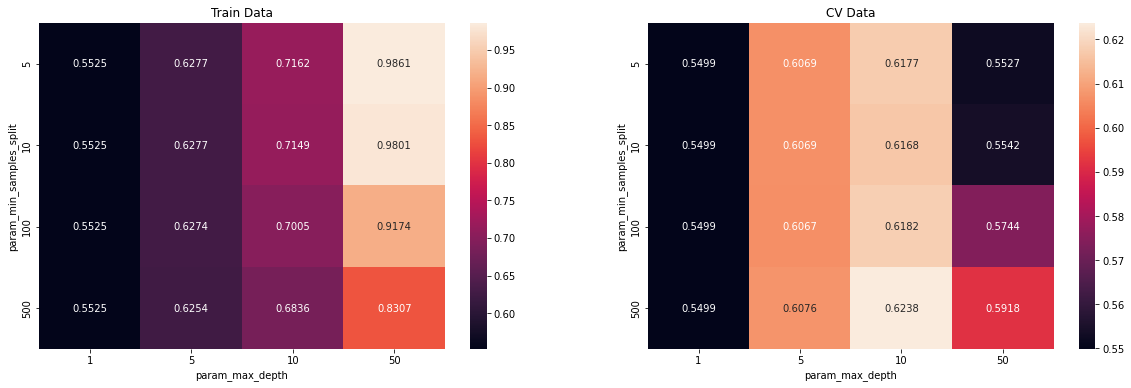

In [ ]:
max_auc_scores = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(max_auc_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_auc_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Data')
ax[1].set_title('CV Data')
plt.show()

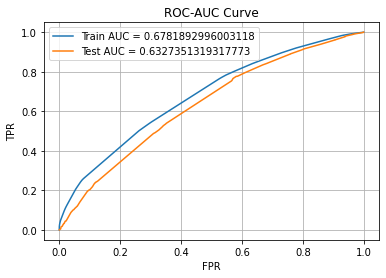

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=500, class_weight='balanced')
dt_clf.fit(X_tr_set_one, y_train )

y_train_predicted = dt_clf.predict_proba(X_tr_set_one)[:,1]
y_test_predicted = dt_clf.predict_proba(X_te_set_one)[:,1]

s1_train_fpr, s1_train_tpr, s1_train_threshold = roc_curve(y_train, y_train_predicted)
s1_test_fpr, s1_test_tpr, s1_test_threshold = roc_curve(y_test, y_test_predicted)

plt.plot(s1_train_fpr, s1_train_tpr, label="Train AUC = "+str(auc(s1_train_fpr, s1_train_tpr)))
plt.plot(s1_test_fpr, s1_test_tpr, label="Test AUC = "+str(auc(s1_test_fpr, s1_test_tpr)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.title('ROC-AUC Curve')
plt.show()

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.3813579229825583 for threshold 0.498
the maximum value of tpr*(1-fpr) 0.34974553520262575 for threshold 0.498
CONFUSION MATRIX OF TRAIN DATA




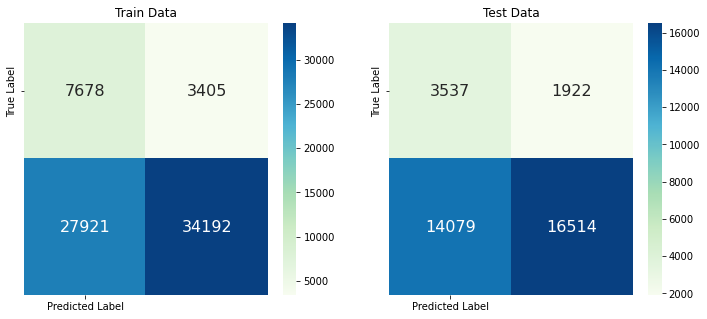

In [ ]:
#Train Data  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
best_tr = find_best_threshold(s1_train_threshold, s1_train_fpr, s1_train_tpr)
best_te = find_best_threshold(s1_test_threshold, s1_test_fpr, s1_test_tpr)

cm_tr = metrics.confusion_matrix(y_train,predict_with_best_t(y_train_predicted, best_tr))  
cm_te = metrics.confusion_matrix(y_test,predict_with_best_t(y_test_predicted, best_te))

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
fig,ax = plt.subplots(1,2, figsize=(12,5)) 

sns.heatmap(cm_tr, xticklabels=['Predicted Label'], yticklabels=['True Label'], annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16},ax=ax[0])
sns.heatmap(cm_te, xticklabels=['Predicted Label'], yticklabels=['True Label'], annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16},ax=ax[1])
ax[0].set_title('Train Data')
ax[1].set_title('Test Data')

plt.show()

In [ ]:
predict=predict_with_best_t(y_test_predicted,best_te)
fpi = []
for i in range(len(y_test)):
    if(y_test[i]==0) & (predict[i] == 1): #GETTING THE FALSE POSITIVE INDICES
        fpi.append(i)
len(fpi)

import pandas as pd
cols = X_test.columns
X_test_fp = pd.DataFrame(columns=cols) # MAKING THE FALSE POSITIVE DATAFRAME
X_test_fp = X_test.iloc[fpi]    
print(X_test_fp.shape)   

(1922, 12)


In [ ]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS)
for word in X_test_fp['essay']:
    val = str(word)                #https://www.geeksforgeeks.org/generating-word-cloud-python/
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

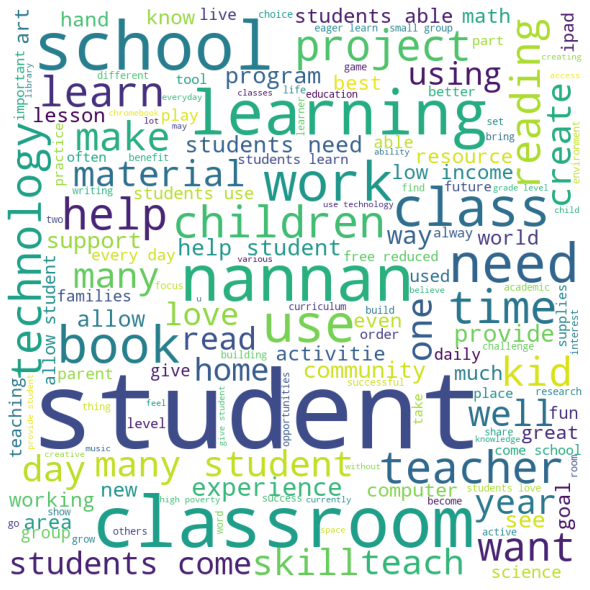

In [ ]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

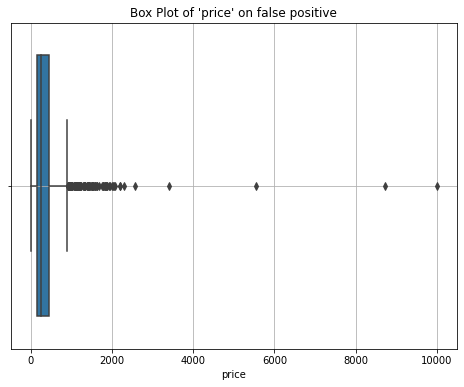

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot('price',data=X_test_fp,orient="v").set_title("Box Plot of 'price' on false positive")
plt.grid()

[9.49531738e-01 2.86160250e-02 7.80437045e-03 7.28407908e-03
 4.16233091e-03 1.56087409e-03 5.20291363e-04 0.00000000e+00
 0.00000000e+00 5.20291363e-04]
[  0.   32.2  64.4  96.6 128.8 161.  193.2 225.4 257.6 289.8 322. ]


Text(0.5, 0, 'teacher_number_of_previously_posted_projects')

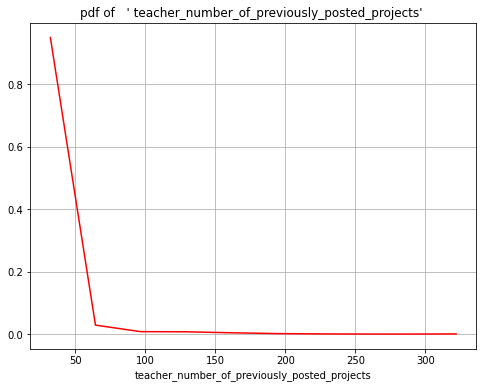

In [ ]:
plt.figure(figsize=(8,6))
plt.grid()
counts, bin_edges = np.histogram(X_test_fp['teacher_number_of_previously_posted_projects'], bins=10, 
                                density = True)
pdf = counts/(sum(counts))
print(pdf);
print(bin_edges)
plt.plot(bin_edges[1:],pdf,color="red")
plt.title("pdf of   ' teacher_number_of_previously_posted_projects' ")
plt.xlabel('teacher_number_of_previously_posted_projects')

### Set 2 : categorical, numerical features + preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)


In [ ]:
glove_vector_path = 'drive/My Drive/Colab Notebooks/gllove_vectors'

### Tfidf W2V on Essay Feature

In [ ]:
import pickle
with open(glove_vector_path, 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# Hence we are now converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())     

    
# Function to generate Word2Vec referencing "4_Reference_Vectorization.ipynb" given in the instruction
def generate_w2v_from_text(essays_text_arr):
  # compute average word2vec for each review.
    tfidf_w2v_vectors = []
    # the avg-w2v for each sentence/review is stored in this list

    for sentence in tqdm(essays_text_arr):  # for each sentence
        vector = np.zeros(300)  # as word vectors are of zero length
        tf_idf_weight = 0
        # num of words with a valid vector in the sentence
        for word in sentence.split():  # for each word in a sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]  # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word] * (
                    sentence.count(word) / len(sentence.split())
                )  # getting the tfidf value for each word
                vector += vec * tf_idf  # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors

X_train_vectorized_tfidf_w2v_essay = generate_w2v_from_text(X_train['essay'].values)
X_test_vectorized_tfidf_w2v_essay = generate_w2v_from_text(X_test['essay'].values)

100%|██████████| 36052/36052 [01:28<00:00, 407.90it/s]


### Stacking All Vectorized Feature

In [ ]:
from scipy.sparse import hstack
X_tr_set_two = hstack((X_train_vectorized_tfidf_w2v_essay, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,X_train_clean_ohe,X_train_clean_sub_ohe,X_train_previous_project_norm,X_train_negative_sent_standardized ,X_train_positive_sent_standardized,X_train_neutral_sent_standardized,X_train_compound_sent_standardized)).tocsr()
X_te_set_two = hstack((X_test_vectorized_tfidf_w2v_essay, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,X_test_clean_ohe,X_test_clean_sub_ohe,X_test_previous_project_norm,X_test_negative_sent_standardized ,X_test_positive_sent_standardized,X_test_neutral_sent_standardized,X_test_compound_sent_standardized)).tocsr()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

DT= DecisionTreeClassifier(class_weight='balanced') 
clf = GridSearchCV(DT, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(X_tr_set_two,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

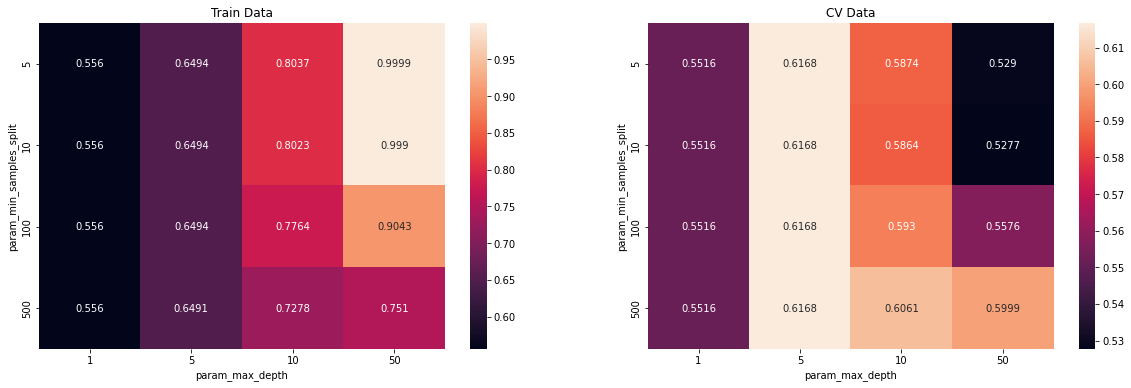

In [ ]:
max_auc_scores  = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(max_auc_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_auc_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Data')
ax[1].set_title('CV Data')
plt.show()

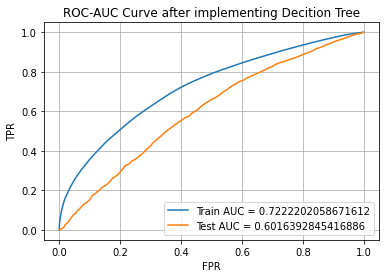

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=500, class_weight='balanced')
dt_clf.fit(X_tr_set_two, y_train )

y_train_predicted = dt_clf.predict_proba(X_tr_set_two)[:,1]
y_test_predicted = dt_clf.predict_proba(X_te_set_two)[:,1]

s2_train_fpr, s2_train_tpr, s2_train_threshold = roc_curve(y_train, y_train_predicted)
s2_test_fpr, s2_test_tpr, s2_test_threshold = roc_curve(y_test, y_test_predicted)

plt.plot(s2_train_fpr, s2_train_tpr, label="Train AUC = "+str(auc(s2_train_fpr, s2_train_tpr)))
plt.plot(s2_test_fpr, s2_test_tpr, label="Test AUC = "+str(auc(s2_test_fpr, s2_test_tpr)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.title('ROC-AUC Curve after implementing Decition Tree')
plt.show()

the maximum value of tpr*(1-fpr) 0.43972522921934426 for threshold 0.503
the maximum value of tpr*(1-fpr) 0.33411008234034867 for threshold 0.505
CONFUSION MATRIX OF TRAIN DATA




Text(0.5, 1.0, 'Test Data')

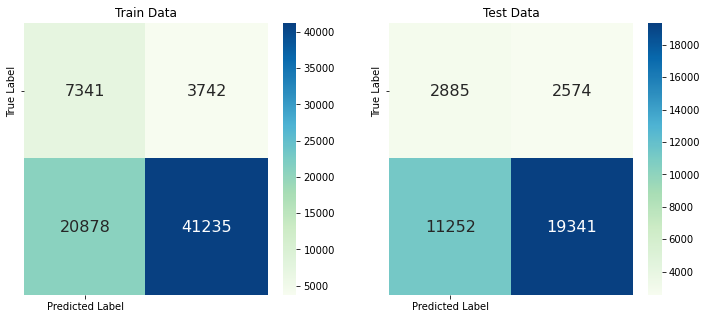

In [ ]:
best_tr = find_best_threshold(s2_train_threshold , s2_train_fpr, s2_train_tpr)
best_te = find_best_threshold(s2_test_threshold, s2_test_fpr, s2_test_tpr)
cm_tr = metrics.confusion_matrix(y_train,predict_with_best_t(y_train_predicted, best_tr))  
cm_te = metrics.confusion_matrix(y_test,predict_with_best_t(y_test_predicted, best_te))
fig,ax = plt.subplots(1,2, figsize=(12,5)) 
print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")

sns.heatmap(cm_tr, xticklabels=['Predicted Label'], yticklabels=['True Label'], annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16},ax=ax[0])
sns.heatmap(cm_te, xticklabels=['Predicted Label'], yticklabels=['True Label'], annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16},ax=ax[1])
ax[0].set_title('Train Data')
ax[1].set_title('Test Data')

In [ ]:
predict=predict_with_best_t(y_test_predicted,best_te)
fpi = []
for i in range(len(y_test)):
    if(y_test[i]==0) & (predict[i] == 1): #GETTING THE FALSE POSITIVE INDICES
        fpi.append(i)
len(fpi)

import pandas as pd
cols = X_test.columns
X_test_fp = pd.DataFrame(columns=cols) # MAKING THE FALSE POSITIVE DATAFRAME
X_test_fp = X_test.iloc[fpi]    
print(X_test_fp.shape)   

(2574, 12)


In [ ]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS)
for word in X_test_fp['essay']:
    val = str(word)                #https://www.geeksforgeeks.org/generating-word-cloud-python/
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

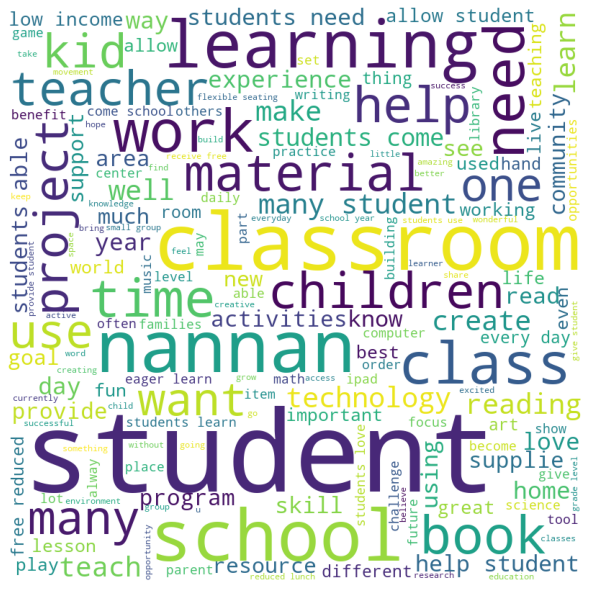

In [ ]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

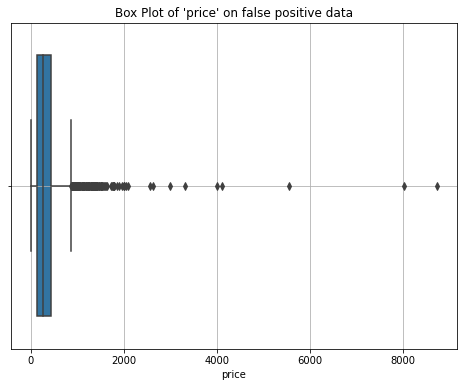

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot('price',data=X_test_fp,orient="v").set_title("Box Plot of 'price' on false positive data")
plt.grid()

[9.56876457e-01 2.64180264e-02 4.66200466e-03 8.15850816e-03
 1.55400155e-03 1.55400155e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77000777e-04]
[  0.   34.3  68.6 102.9 137.2 171.5 205.8 240.1 274.4 308.7 343. ]


Text(0.5, 0, 'teacher_number_of_previously_posted_projects')

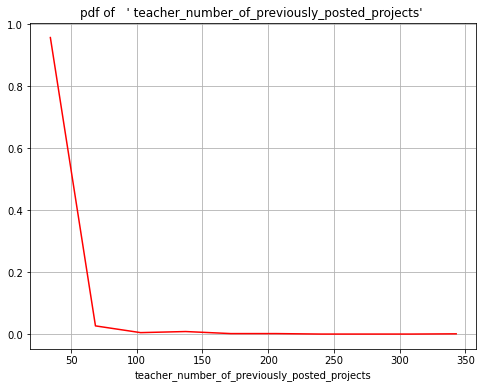

In [ ]:
plt.figure(figsize=(8,6))
plt.grid()
counts, bin_edges = np.histogram(X_test_fp['teacher_number_of_previously_posted_projects'], bins=10, 
                                density = True)
pdf = counts/(sum(counts))
print(pdf);
print(bin_edges)
plt.plot(bin_edges[1:],pdf,color="red")
plt.title("pdf of   ' teacher_number_of_previously_posted_projects' ")
plt.xlabel('teacher_number_of_previously_posted_projects')

#Calculating Non-zero feature importance on Set-1 Features

### Apply DT on Non Zero Feature of Set 1

In [ ]:
dt_clf = DecisionTreeClassifier(class_weight='balanced')

X_tr_set_one_csr = X_tr_set_one.tocsr()
dt_clf.fit(X_tr_set_one_csr, y_train)

X_te_set_one_csr = X_te_set_one.tocsr()

imp_features = np.array(dt_clf.feature_importances_)

X_tr_set_one_imp_features = X_tr_set_one_csr[:, imp_features > 0 ]
X_te_set_one_imp_features = X_te_set_one_csr[:, imp_features > 0 ]

### Hyper Parameter Tuning

In [ ]:
from sklearn.svm import LinearSVC
svc = LinearSVC()

hyperparams_svc_gridsearchcv =  {"C": np.logspace(0, 4, 10)}

gridsearch_svc = GridSearchCV(svc, hyperparams_svc_gridsearchcv, cv=3)

gridsearch_svc.fit(X_tr_set_one_imp_features, y_train )

print('Best Params from GridSearchCV with Important Features ', gridsearch_svc.best_params_)

Best Params from GridSearchCV with Important Features  {'C': 1.0}


Text(0.5, 0, 'False Positive Rate Imp_features')

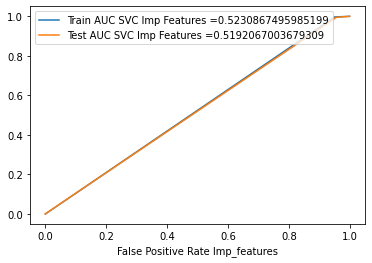

In [ ]:
svc = LinearSVC(C=1)
svc.fit(X_tr_set_one_imp_features, y_train )

y_train_pred = svc.predict(X_tr_set_one_imp_features)
y_test_pred = svc.predict(X_te_set_one_imp_features)

train_fpr_imp_features, train_tpr_imp_features, train_thres_imp_features = roc_curve(y_train, y_train_pred)
test_fpr_imp_features, test_tpr_imp_features, test_thres_imp_features = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr_imp_features, train_tpr_imp_features, label="Train AUC SVC Imp Features ="+str(auc(train_fpr_imp_features, train_tpr_imp_features)))
plt.plot(test_fpr_imp_features, test_tpr_imp_features, label="Test AUC SVC Imp Features ="+str(auc(test_fpr_imp_features, test_tpr_imp_features)))

plt.legend()

plt.xlabel("False Positive Rate Imp_features")

In [ ]:
confusion_matrix(y_train, y_train_pred)

array([[  546, 10537],
       [  192, 61921]])

In [ ]:
confusion_matrix(y_test, y_test_pred)

array([[  237,  5222],
       [  153, 30440]])

In [ ]:
from prettytable import PrettyTable  # http://zetcode.com/python/prettytable/
from prettytable import ALL as ALL
table=PrettyTable(hrules=ALL)
table.field_names = [ "Sl.N0","Vectorizer", "Model", "Hyper Parameter", "Train-AUC","Test-AUC"] # 
table.add_row([1,"TFIDF", "DECSION TREE", "max_depth =10 , min_samples_split=500", 0.67818, 0.63273])
table.add_row([2,"TFIDF W2V", "DECSION TREE"," max_depth =5 , min_samples_split=500", 0.72222, 0.60163])
table.add_row([3,"TFIDF NON-ZERO FI", "DECSION TREE", "max_depth =10 , min_samples_split=500", 0.52308, 0.51920])
print(table)

+-------+-------------------+--------------+---------------------------------------+-----------+----------+
| Sl.N0 |     Vectorizer    |    Model     |            Hyper Parameter            | Train-AUC | Test-AUC |
+-------+-------------------+--------------+---------------------------------------+-----------+----------+
|   1   |       TFIDF       | DECSION TREE | max_depth =10 , min_samples_split=500 |  0.67818  | 0.63273  |
+-------+-------------------+--------------+---------------------------------------+-----------+----------+
|   2   |     TFIDF W2V     | DECSION TREE |  max_depth =5 , min_samples_split=500 |  0.72222  | 0.60163  |
+-------+-------------------+--------------+---------------------------------------+-----------+----------+
|   3   | TFIDF NON-ZERO FI | DECSION TREE | max_depth =10 , min_samples_split=500 |  0.52308  |  0.5192  |
+-------+-------------------+--------------+---------------------------------------+-----------+----------+
